In [15]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from utils.ArticlesParser import process_articles_directory
from utils.Graph import *
from utils.Preprocessing import *
from utils.Visualization import *
from sentence_transformers import SentenceTransformer, util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

# change_name_files_plaintext_articles(data_path)

parsed_articles = process_articles_directory(articles_path)
df = pd.DataFrame(parsed_articles, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Second_Crusade,"[Military History and War, Religious disputes]",The Second Crusade was the second major crusad...
1,Navassa_Island,[North American Geography],"Navassa Island (French: La Navase, Haitian Kre..."
2,Evan_Rachel_Wood,"[Actors, models and celebrities]","Evan Rachel Wood (born September 7, 1987) is a..."
3,Tropical_Storm_Henri_(2003),[Storms],Tropical Storm Henri was a weak tropical storm...
4,Final_Fantasy_Adventure,[Computer & Video games],Final Fantasy Adventure (originally released i...


In [17]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [18]:
# This needs to calculate the embeddings for each article and description, takes time.
embedded_articles = articles_to_embeddings(parsed_articles, model)

In [19]:
for title in embedded_articles:
    score = util.dot_score(*embedded_articles[title])
    if score < 0.2:
        print(f"{title} score: {float(score):.4f}")

Lottie_Dod score: 0.1621
Cheers score: 0.1901
Amur score: 0.1967


In [20]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john_embedding, john_desc_embedding = embedded_articles["John_W._Campbell"]
isaac_embedding, isaac_desc_embedding = embedded_articles["Isaac_Asimov"]
print(f"Cosine similarity between article names: {float(util.dot_score(john_embedding, isaac_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(john_desc_embedding, isaac_desc_embedding)):.4f}")

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick_embedding, limerick_desc_embedding = embedded_articles["Limerick"]
poetry_embedding, poetry_desc_embedding = embedded_articles["Poetry"]
print(f"Cosine similarity between article names: {float(util.dot_score(limerick_embedding, poetry_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(limerick_desc_embedding, poetry_desc_embedding)):.4f}")

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter_embedding, winter_desc_embedding = embedded_articles["Winter"]
summer_embedding, summer_desc_embedding = embedded_articles["Summer"]
print(f"Cosine similarity between article names: {float(util.dot_score(winter_embedding, summer_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(winter_desc_embedding, summer_desc_embedding)):.4f}")

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2334
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


### Discussion
Intuitively, articles should be linked if the cosine similarity between descriptions is higher than a certain threshold, while being close to the article names cosine similarity. But it is easier to let a neural network determine the weights while passing on both the article names and descriptions embeddings as variables for each node.

In [21]:
df_links = preprocessing_links(data_path)
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


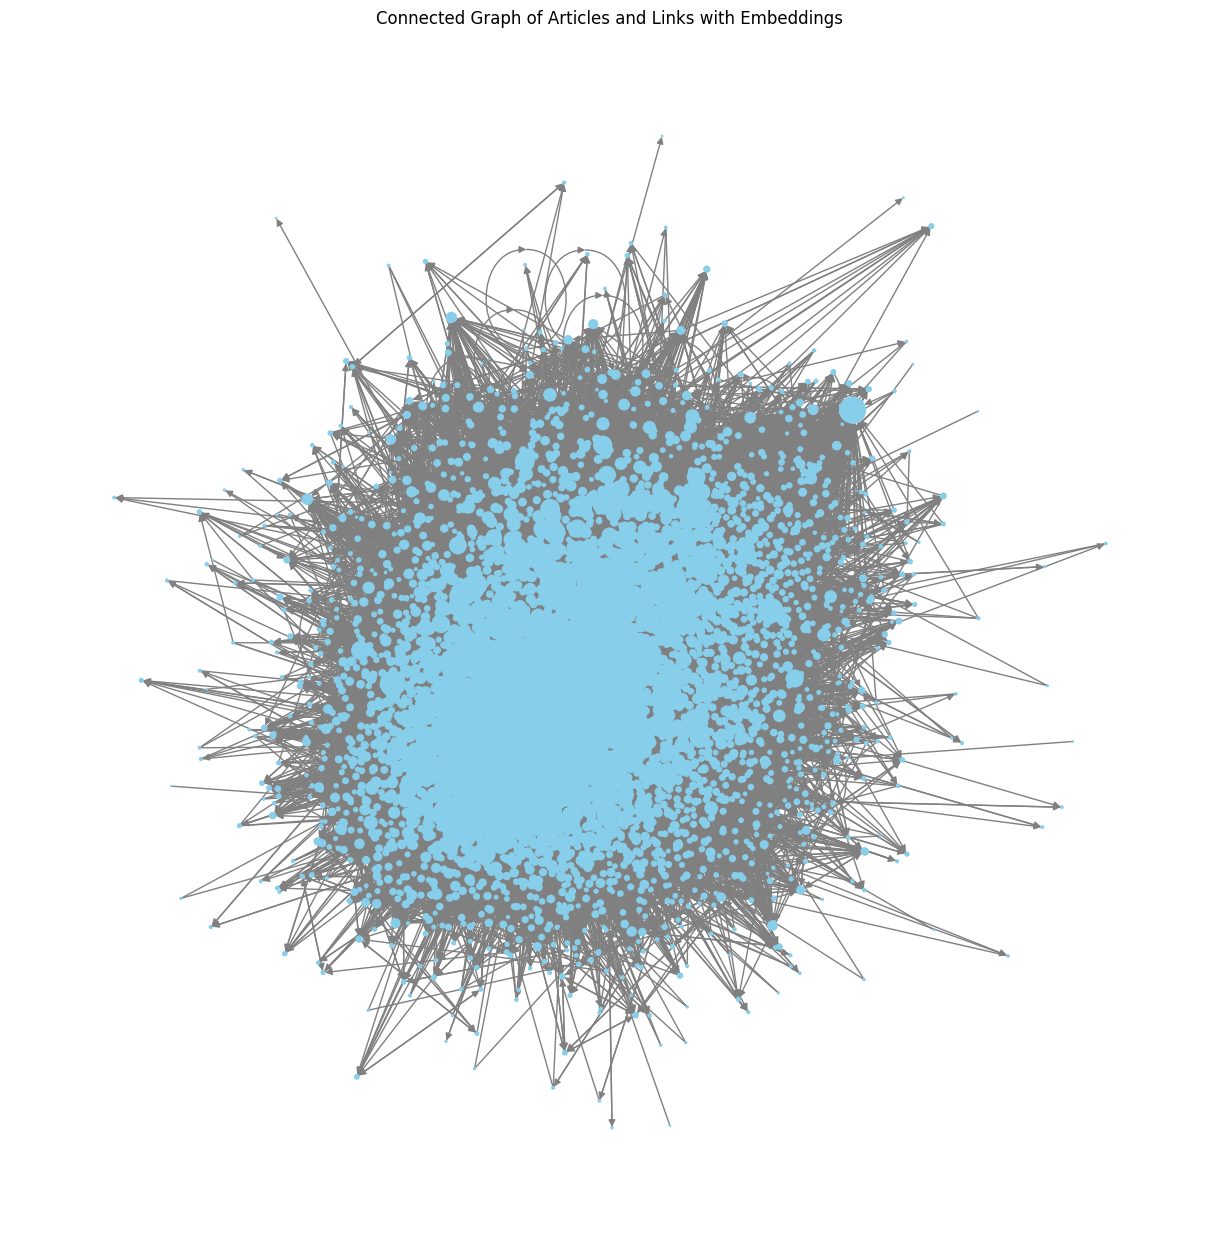

In [22]:
G=create_graph(embedded_articles, df_links)
visualize_graph(G)

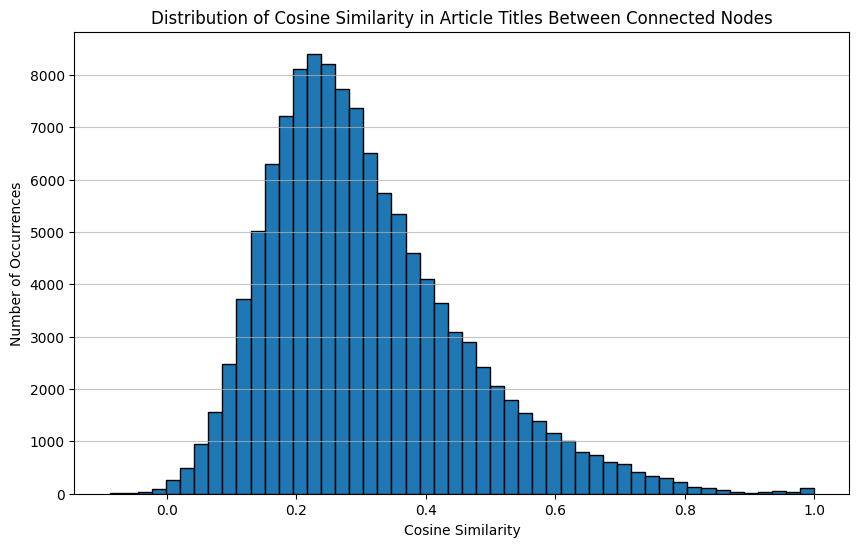

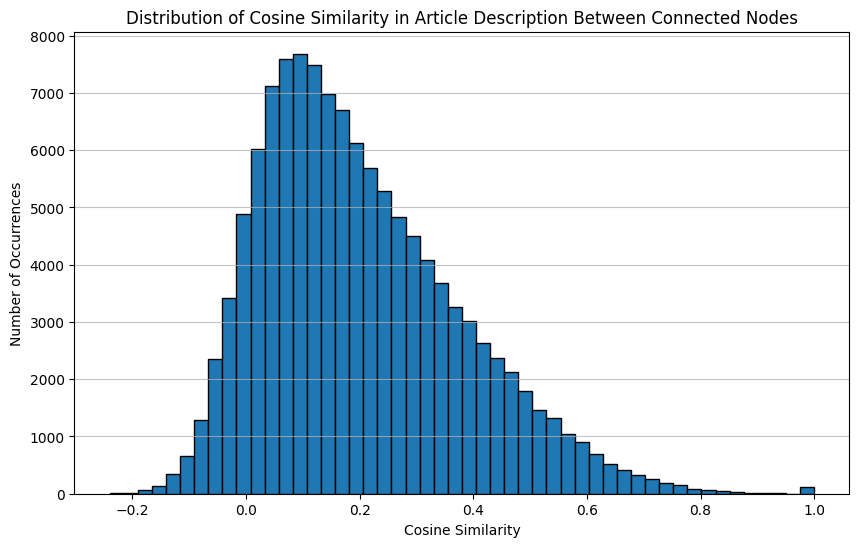

In [23]:
visualize_connected_node_similarity_distributions(G)

## Description

Now to compare these distribution with the cosine similarities of article titles and descriptions between unconnected nodes, we will take a representative sample of the articles and calculate their cosine similarities.

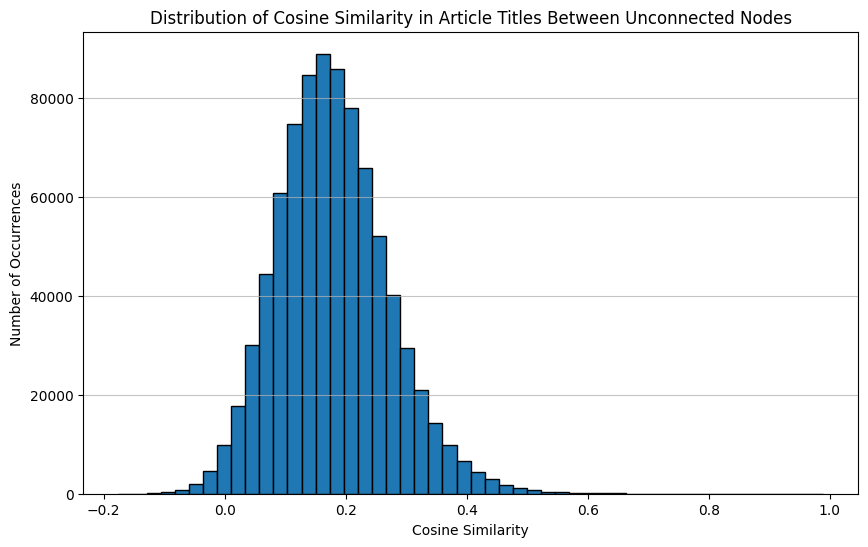

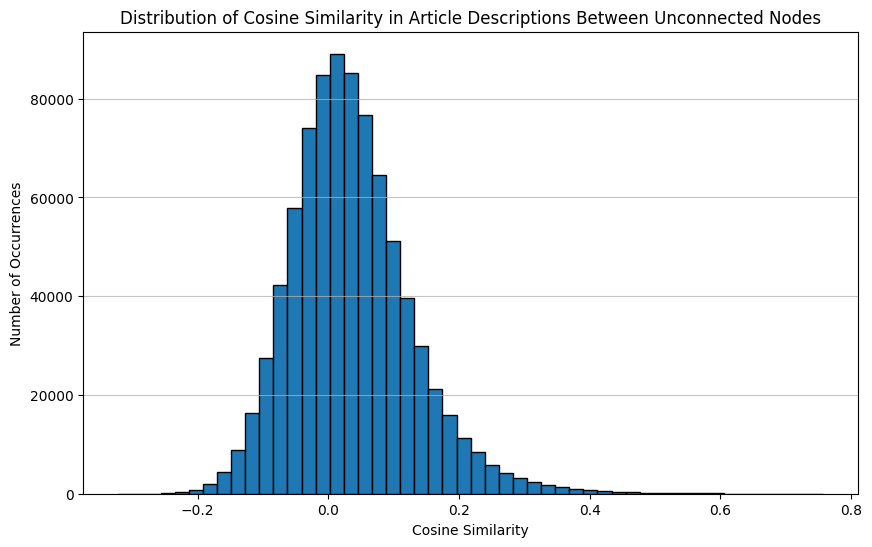

In [24]:
similarities = visualize_unconnected_node_similarity_distributions(G, len(G.nodes)//5)

In [25]:
for s in similarities:
    if s['title_similarity'] > 0.7 and s['description_similarity'] > 0.6:
        print(s['source'] + ' ' + s['target'])

6-2-0 2-6-0
Global Global_city
Global_city Global
Pope_Benedict_XVI Pope_Pius_XII
Pope_Pius_XII Pope_Benedict_XVI
2-6-0 6-2-0
Wood_Pigeon Pink_Pigeon
Mars_Exploration_Rover Exploration_of_Mars
Exploration_of_Mars Mars_Exploration_Rover
Pink_Pigeon Wood_Pigeon
